# Day 3: Classification Models

On the first day, we learned about the embeddings and yesterday about the Factor Models to reduce the dataset's dimensionality. Our goal today is to build a classification model to classify the images into 'active' and 'inactive'.

## 1. Loading and Exploring Data
Like yesterday, we are going to clone the repo to get the data. We added three new files with the latent features from the 3 factor models we explored in day 2.


In [1]:
#! git clone https://github.com/ai4all-sfu/comp-biology-2020.git

In [2]:
#Loading the libraries 

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


#Loading Files we cloned from github 
embeddings = pd.read_pickle('comp-biology-2020/embeddings.pkl', compression = 'xz')
metadata = pd.read_pickle('comp-biology-2020/metadata.pkl', compression = 'xz')

#Selecting only the columns 'site_id' and 'disease_condition'
metadata = metadata.iloc[:,[0,7]]

#Adding the target 'disease_condition' on embeddings dataset and transforming to 0-1 scale

embeddings01 = embeddings.set_index('site_id').join(metadata.set_index('site_id'))
print(embeddings.head())

             site_id  feature_0  ...  feature_1022  feature_1023
24  HRCE-1_10_AA08_1   2.297975  ...     -0.286453     -1.424416
25  HRCE-1_10_AA08_2   2.023117  ...      0.145723     -1.794530
35  HRCE-1_10_AA10_4   2.725714  ...      0.033494     -1.130605
56  HRCE-1_10_AA16_1   2.525933  ...     -0.127639     -1.530562
57  HRCE-1_10_AA16_2   2.462103  ...     -0.313509     -1.556824

[5 rows x 1025 columns]


In [3]:
# Loading latent features from yesterday  (they are sorted in the same order of the embeddings dataset)

pca = np.load('comp-biology-2020/latent_features/pca50.npz')['arr_0']
nmf = np.load('comp-biology-2020/latent_features/mf60.npz')['arr_0']
aut = np.load('comp-biology-2020/latent_features/a32.npz')['arr_0']

print('PCA Dimensions: ',pca.shape, '\nMF Dimensions: ',nmf.shape, '\nAutoencoder Dimensions: ',aut.shape)

PCA Dimensions:  (16000, 50) 
MF Dimensions:  (16000, 60) 
Autoencoder Dimensions:  (16000, 32)


In the left side, click in 'Files' and 'Upload to Session Storage' as shown in the image below:  
![alt text](https://i.imgur.com/oLk88Mu.jpg)

Upload the files from yesterday's exercise: 'mypca.npz' and 'mysvd.npz' 

In [4]:
mypca = np.load('mypca.npz')['arr_0']
mymf = np.load('mymf.npz')['arr_0']

print('My PCA Dimensions: ',mypca.shape, '\nMy MF Dimensions: ',mymf.shape) 

My PCA Dimensions:  (16000, 50) 
My MF Dimensions:  (16000, 60)



Now let's check the target with the disease condition. Based on the cell image, we want to identify if it is active for SARS-CoV-2 or inactive.

In [5]:
print(embeddings01['disease_condition'].value_counts()) 


active      8000
inactive    8000
Name: disease_condition, dtype: int64


To use this information in our classification models, we will transform this column in a binary variable. If the disease condition is active, it will receive the value 1, and 0 is inactive.

In [6]:
target = embeddings01['disease_condition'].replace({'active':1, 'inactive':0}).tolist() 

print(embeddings01['disease_condition'].value_counts()) 
print("Before transforming:" ,embeddings01['disease_condition'][0:5].tolist())
print("After transforming:",target[0:5])

active      8000
inactive    8000
Name: disease_condition, dtype: int64
Before transforming: ['inactive', 'inactive', 'active', 'inactive', 'inactive']
After transforming: [0, 0, 1, 0, 0]


During our analysis, we will also check one specific image to have an idea how the models work. You can see the image below: ![alt text](https://i.imgur.com/0CnrNXp.png)

And according to our metadata, this is an 'active' cell. 

In [7]:
metadata[metadata['site_id']=='VERO-2_2_Z45_1']

,site_id,disease_condition
74990,VERO-2_2_Z45_1,active


In [8]:
#Bulding a dictionary with all the features 
features = {'PCA': pca, 'MF': nmf, 'Autoencoder':aut, 'MyPCa': mypca, 'MyMF': mymf}

indice = embeddings01.index.get_loc('VERO-2_2_Z45_1') 
features_example = {'PCA': pca[indice], 'MF': nmf[indice], 
                    'Autoencoder':aut[indice], 'MyPCa': mypca[indice], 'MyMF': mymf[indice]}

## 2. Classification Models

Our task is to classify if a cell image is infected (class 'active') or not (class 'inactive').


We will use sklearn to import our classifiers. The three models we are going to explore are Logistic Regression, KNN Classifier, and Random Forest.

In [9]:
#import os
#import glob
#import cv2
import warnings
#from matplotlib import pyplot
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

warnings.filterwarnings('ignore')
seed      = 9

# variables to hold the results and models' names
results = pd.DataFrame(columns=['model', 'features','accuracy_train', 'accuracy_test', 'precision_test', 'recall_test'])
active_image_example = pd.DataFrame(columns=['model', 'features','predicted_target'])

The first model we are going to explore is Logistic Regression. 



In [10]:
lr = LogisticRegression(random_state=seed)
model_name = 'Logistic Regression'
for f in features:
  #1) Split the features in training and testing set 
  X_train, X_test, y_train, y_test = train_test_split(features[f],target , test_size=0.3, random_state=seed) 
  #2) Fit the model
  model = lr.fit(X_train,y_train)
  #3) Predict the labels for the training set and testing set
  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)
  #4) Save the results and calculate the accuracy 
  output = {'model':model_name, 
            'features':f, 
            'accuracy_train':accuracy_score(y_train,y_train_pred), 
            'accuracy_test':accuracy_score(y_test,y_test_pred),
            'precision_test':precision_score(y_test,y_test_pred) ,
            'recall_test':recall_score(y_test,y_test_pred) }
  results = results.append(output,ignore_index=True)
  active_image_example = active_image_example.append({'model':model_name, 'features':f, 'predicted_target':model.predict(features_example[f].reshape(1,-1))}, 
                              ignore_index=True)

print(results)

                 model     features  ...  precision_test  recall_test
0  Logistic Regression          PCA  ...        0.990426     0.947544
1  Logistic Regression           MF  ...        0.991814     0.958368
2  Logistic Regression  Autoencoder  ...        0.560015     0.639051
3  Logistic Regression        MyPCa  ...        0.990426     0.947544
4  Logistic Regression         MyMF  ...        0.991814     0.958368

[5 rows x 6 columns]


Now we are going to explore Random Forest. 

In [11]:
rf = RandomForestClassifier(n_estimators=30, random_state=seed)
model_name = 'Random Forest'

for f in features:
  #1) Split the features in training and testing set 
  X_train, X_test, y_train, y_test = train_test_split(features[f],target , test_size=0.3, random_state=seed) 
  #2) Fit the model
  model = rf.fit(X_train,y_train)
  #3) Predict the labels for the training set and testing set
  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)
  #4) Save the results and calculate the accuracy 
  output = {'model':model_name, 
            'features':f, 
            'accuracy_train':accuracy_score(y_train,y_train_pred), 
            'accuracy_test':accuracy_score(y_test,y_test_pred),
            'precision_test':precision_score(y_test,y_test_pred) ,
            'recall_test':recall_score(y_test,y_test_pred) }
  results = results.append(output,ignore_index=True)
  active_image_example = active_image_example.append({'model':model_name, 'features':f, 'predicted_target':model.predict(features_example[f].reshape(1,-1))}, 
                              ignore_index=True)

print(results)

                 model     features  ...  precision_test  recall_test
0  Logistic Regression          PCA  ...        0.990426     0.947544
1  Logistic Regression           MF  ...        0.991814     0.958368
2  Logistic Regression  Autoencoder  ...        0.560015     0.639051
3  Logistic Regression        MyPCa  ...        0.990426     0.947544
4  Logistic Regression         MyMF  ...        0.991814     0.958368
5        Random Forest          PCA  ...        0.974037     0.937136
6        Random Forest           MF  ...        0.975945     0.945878
7        Random Forest  Autoencoder  ...        0.564993     0.501249
8        Random Forest        MyPCa  ...        0.974037     0.937136
9        Random Forest         MyMF  ...        0.975945     0.945878

[10 rows x 6 columns]


### Activity 1: 

Can you now fit the KNN by yourself? 

In [12]:
knn = KNeighborsClassifier()
model_name = 'KNN'

#ADD YOUR CODE HERE

#START - DELETE
for f in features:
  #1) Split the features in training and testing set 
  X_train, X_test, y_train, y_test = train_test_split(features[f],target , test_size=0.3, random_state=seed) 
  #2) Fit the model
  model = knn.fit(X_train,y_train)
  #3) Predict the labels for the training set and testing set
  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)
  #4) Save the results and calculate the accuracy 
  output = {'model':model_name, 
            'features':f, 
            'accuracy_train':accuracy_score(y_train,y_train_pred), 
            'accuracy_test':accuracy_score(y_test,y_test_pred),
            'precision_test':precision_score(y_test,y_test_pred) ,
            'recall_test':recall_score(y_test,y_test_pred) }
  active_image_example = active_image_example.append({'model':model_name, 'features':f, 'predicted_target':model.predict(features_example[f].reshape(1,-1))}, 
                              ignore_index=True)
  results = results.append(output,ignore_index=True)
#END - DELETE

print(results)

                  model     features  ...  precision_test  recall_test
0   Logistic Regression          PCA  ...        0.990426     0.947544
1   Logistic Regression           MF  ...        0.991814     0.958368
2   Logistic Regression  Autoencoder  ...        0.560015     0.639051
3   Logistic Regression        MyPCa  ...        0.990426     0.947544
4   Logistic Regression         MyMF  ...        0.991814     0.958368
5         Random Forest          PCA  ...        0.974037     0.937136
6         Random Forest           MF  ...        0.975945     0.945878
7         Random Forest  Autoencoder  ...        0.564993     0.501249
8         Random Forest        MyPCa  ...        0.974037     0.937136
9         Random Forest         MyMF  ...        0.975945     0.945878
10                  KNN          PCA  ...        0.997680     0.895087
11                  KNN           MF  ...        0.996840     0.919234
12                  KNN  Autoencoder  ...        0.536268     0.532473
13    

Let us use a scatter plot to compare the performance of all the three machine learning algorithms.

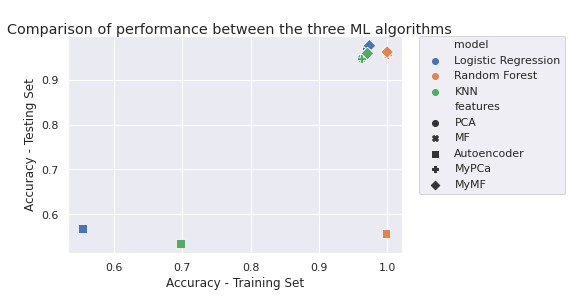

In [13]:
#Plot with comparison
import seaborn as sns; sns.set()

results["model"] = results["model"].astype('category')
results["features"] = results["features"].astype('category')

fig = plt.figure()
fig.suptitle('\nComparison of performance between the three ML algorithms')
ax = sns.scatterplot(x="accuracy_train", y="accuracy_test", hue="model", style="features", data=results, s = 80)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Accuracy - Training Set')
plt.ylabel('Accuracy - Testing Set')
plt.show()

The autoencoder features seem to have worse results. Let's try to remove it and make our plot again.

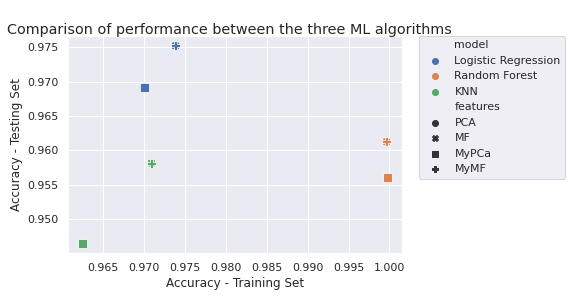

In [14]:
results_without_autoencoder = results[results['features']!='Autoencoder']
results_without_autoencoder["model"] = results_without_autoencoder["model"].astype('category')
results_without_autoencoder["features"] = results_without_autoencoder["features"].astype('category')

fig = plt.figure()
fig.suptitle('\nComparison of performance between the three ML algorithms')
ax = sns.scatterplot(x="accuracy_train", y="accuracy_test", hue="model", style="features", s = 80, data=results_without_autoencoder)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Accuracy - Training Set')
plt.ylabel('Accuracy - Testing Set')
plt.show()

### Activity 2

Based on the plot results, what combination of Model and Features do you think have the best results?

### Activity Advanced Level Only

Now it's your turn to explore a classification model. 

There is classification model called [SVM](https://https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html). After reading about this type of model, try to implement it by yourself! Before adding the outputs to the 'results' file, explore some of the parameters available. Then, you can add your best SVM model in the 'results' file.



In [15]:
#ADD HERE YOUR CODE 


#Delete everything 
from sklearn.svm import SVC
svm = SVC(gamma='auto')
model_name = 'SVM'

for f in features:
  #1) Split the features in training and testing set 
  X_train, X_test, y_train, y_test = train_test_split(features[f],target , test_size=0.3, random_state=seed) 
  #2) Fit the model
  model = svm.fit(X_train,y_train)
  #3) Predict the labels for the training set and testing set
  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)
  #4) Save the results and calculate the accuracy 
  output = {'model':model_name, 
            'features':f, 
            'accuracy_train':accuracy_score(y_train,y_train_pred), 
            'accuracy_test':accuracy_score(y_test,y_test_pred),
            'precision_test':precision_score(y_test,y_test_pred) ,
            'recall_test':recall_score(y_test,y_test_pred) }
  active_image_example = active_image_example.append({'model':model_name, 'features':f, 'predicted_target':model.predict(features_example[f].reshape(1,-1))}, 
                              ignore_index=True)
  results = results.append(output,ignore_index=True)



In [16]:
#ADD HERE A PLOT COMPARING ALL MODELS

## 3. Convolutional Neural Network

In the previous section, we explored classification models with the features we built yesterday.

Now, we will explore one last model, called Convolutional Neural Network (CNN). The difference between this model and the others is that we will use as input the embedding file.

While the other models work for all types of inputs (images, tabular data, others), this CNN model receives as input images embeddings. To use the CNN model, we will modify a bit the format of the input data (embeddings file) to fit the form required.

In [17]:
from keras.utils import np_utils

#Expanding the dimensions 
trainData = np.expand_dims(embeddings01.drop('disease_condition',axis=1), axis=2)

#Splitting into training data and testing data
X_train, X_test, y_train, y_test = train_test_split(trainData,target, test_size=0.3, random_state=7)

# number of samples in training data
print("Number of training samples:", X_train.shape[0])
# number of samples in testing data
print("Number of testing samples:", X_test.shape[0])
# number of features used
# this is a vector of features extracted 
print("Number of features:", X_train.shape[1])

#convert the train and test labels to np arrays
y_train01=np.array(y_train)
y_test01=np.array(y_test)

print(y_train[0:5])
#Convert the array of labeled data to one-hot vector
y_train = np_utils.to_categorical(y_train01)
y_test = np_utils.to_categorical(y_test01)

#Expand the dimensions of train and test feature vector dataset into 3D
#x_traincnn = np.expand_dims(X_train, axis=2)
#x_testcnn = np.expand_dims(X_test, axis=2)

print(X_train.shape) 
print(X_train.shape)
print(y_train.shape) 
print(y_test.shape)


Using TensorFlow backend.


Number of training samples: 11200
Number of testing samples: 4800
Number of features: 1024
[0, 0, 1, 1, 0]
(11200, 1024, 1)
(11200, 1024, 1)
(11200, 2)
(4800, 2)


We use keras library to build a sequential basic CNN model consisting of 4 convolutional layers and one fully connected layer at the end supported by softmax activation function for classification. Each convolutional layer is followed by a maxpool operation and a dropout layer.

The code below is going to take a couple of minutes. 

In [18]:
#Loading libraries
from sklearn.metrics import accuracy_score
import keras
from keras.models import Sequential
from keras.layers import Input, Flatten, Dropout, Activation, Dense
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D, LSTM
from keras.models import Model
from keras.layers import Input, Dense
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from numpy import newaxis

model = Sequential()
model.add(Conv1D(32,3,padding='same',activation='relu',input_shape=(1024,1))) 
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.1))
model.add(Conv1D(32,3,padding='same',activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.1))
model.add(Conv1D(64,3,padding='same',activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.1))
model.add(Conv1D(64,3,padding='same',activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(units=2,activation = 'softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

#Fit the model, train for 10 epochs, with batch size = 32
cnnhistory=model.fit(X_train, np.array(y_train), batch_size=32, epochs=10, validation_data=(X_test, np.array(y_test)))
#Print the training accuracy obtained in each epoch.
print("Accuracy: {:.2f}%".format(cnnhistory.history['accuracy'][-1]*100))
#Print the validation accuracy obtained in each epoch.
print("Validation Accuracy: {:.2f}%".format(cnnhistory.history['val_accuracy'][-1]*100))

Train on 11200 samples, validate on 4800 samples
Epoch 1/10
11200/11200 [==============================] - 27s 2ms/step - loss: 0.2115 - accuracy: 0.9112 - val_loss: 0.0904 - val_accuracy: 0.9702
Epoch 2/10
11200/11200 [==============================] - 27s 2ms/step - loss: 0.1046 - accuracy: 0.9658 - val_loss: 0.0865 - val_accuracy: 0.9746
Epoch 3/10
11200/11200 [==============================] - 27s 2ms/step - loss: 0.0873 - accuracy: 0.9715 - val_loss: 0.1169 - val_accuracy: 0.9652
Epoch 4/10
11200/11200 [==============================] - 27s 2ms/step - loss: 0.0856 - accuracy: 0.9731 - val_loss: 0.0893 - val_accuracy: 0.9733
Epoch 5/10
11200/11200 [==============================] - 27s 2ms/step - loss: 0.0814 - accuracy: 0.9746 - val_loss: 0.0816 - val_accuracy: 0.9750
Epoch 6/10
11200/11200 [==============================] - 27s 2ms/step - loss: 0.0758 - accuracy: 0.9763 - val_loss: 0.0862 - val_accuracy: 0.9756
Epoch 7/10
11200/11200 [==============================] - 27s 2ms/ste

In [19]:
y_train_pred = model.predict_classes(X_train)
y_test_pred = model.predict_classes(X_test)

output = {'model':'CNN', 
            'features':'embeddings', 
            'accuracy_train':accuracy_score(y_train01,y_train_pred), 
            'accuracy_test':accuracy_score(y_test01,y_test_pred), 
            'precision_test':precision_score(y_test01,y_test_pred) ,
            'recall_test':recall_score(y_test01,y_test_pred)  }
active_image_example = active_image_example.append({'model':'CNN', 'features':'embeddings', 'predicted_target':model.predict_classes(trainData[indice].reshape(1,1024,1))}, 
                              ignore_index=True)
results = results.append(output,ignore_index=True)



Let's check how each model predicted the results of the image we used as example. 

In [29]:
active_image_example['predicted_target'] = ['inactive' if item==0 else 'active' for item in active_image_example['predicted_target']]
active_image_example

,model,features,predicted_target
0,Logistic Regression,PCA,active
1,Logistic Regression,MF,active
2,Logistic Regression,Autoencoder,active
3,Logistic Regression,MyPCa,active
4,Logistic Regression,MyMF,active
5,Random Forest,PCA,active
6,Random Forest,MF,active
7,Random Forest,Autoencoder,active
8,Random Forest,MyPCa,active
9,Random Forest,MyMF,active


It looks like all our models predicted this image correctly! :D 

### Activity 3:
 
Create two plots to compare the previously explored models (CNN, KNN, LR, RF, others).

1. Accuracy on training data *versus* testing data; 
2. Precision *versus* Recall on testing data. 

Given a set of unlabelled cell images, if you had to choose only one model to classify if they are infected (label ‘active’) by SARS-CoV-2 or not (label ‘inactive’), which one would be? 



In [21]:
#ADD CODE HERE FOR ACTIVITY # 

results

,model,features,accuracy_train,accuracy_test,precision_test,recall_test
0,Logistic Regression,PCA,0.970000,0.969167,0.990426,0.947544
1,Logistic Regression,MF,0.973839,0.975208,0.991814,0.958368
2,Logistic Regression,Autoencoder,0.555089,0.568125,0.560015,0.639051
3,Logistic Regression,MyPCa,0.970000,0.969167,0.990426,0.947544
4,Logistic Regression,MyMF,0.973839,0.975208,0.991814,0.958368
5,Random Forest,PCA,0.999732,0.956042,0.974037,0.937136
6,Random Forest,MF,0.999643,0.961250,0.975945,0.945878
7,Random Forest,Autoencoder,0.997946,0.557292,0.564993,0.501249
8,Random Forest,MyPCa,0.999732,0.956042,0.974037,0.937136
9,Random Forest,MyMF,0.999643,0.961250,0.975945,0.945878
